In [5]:
import json
import requests
import numpy as np
import matplotlib.pyplot as plt
import subprocess

In [6]:
plt.rcParams.update({'font.size': 22})
# Set rcParams for matplotlib so all plots have opaque background
plt.rcParams['figure.facecolor'] = 'white'

# Checking Progress of FAH Project

This notebook uses API calls to pull down project data about how much data a FAH project\
has collected so far. With this you can check for the progress of projects. 

# Define key variables

Also define paths to your license and key files.

In [52]:
project_number = 17602
num_ns_per_wu = 10 # 10 ns per work unit - this could change depending on the project
license_path = "./2024-may-15-fah-cert-chain.pem"
key_path = "./private.pem"
work_server_url = "https://pllwskifah1.mskcc.org" #Ensure the WS URL is correct for your project

## Pull down summary information from the API

Now use requests and json to pull down the JSON file returned by the API

In [53]:
# use requests to get the project data
r = requests.get("%s/api/projects/%s" % (work_server_url, project_number), 
                 cert=(license_path, key_path))
project_data = r.json()

In [54]:
# assert that len(project_data) = 20 to ensure a correct response was received from the WS
try: 
    assert len(project_data) == 20
    print("Project data received successfully")
except AssertionError as e:
    print("Error: %s" % e)
    print("Ensure the WS URL is correct for your project")
    print("Ensure the license and key paths are correct")
    print("Ensure the project number is correct")

Project data received successfully


## Process summary API JSON file

In [55]:
wu_hist = np.asarray(project_data['histogram'])
wu_gens = int(project_data['gens']) # the max number of possible generations being histogrammed
wu_total = int(project_data['gens_completed'])
print("Number of max possible gens: %s" % wu_gens)
print("Number of WUs completed: %s" % wu_total)
print("Total dataset so far: %s nanoseconds" % (wu_total*num_ns_per_wu))

Number of max possible gens: 250
Number of WUs completed: 136428
Total dataset so far: 1364280 nanoseconds


In [56]:
# Condense the histogram to stop at the last generation with work units
# find where the last work unit was generated
trunc_ind = np.where(wu_hist > 0)[0][-1] # trunc_ind indicates the bin that contains the longest trajectory
wu_hist_trunc = wu_hist[:trunc_ind+1] # truncate the histogram to only include the bins with work units

# Convert trunc_ind also to the max possible generation run
trunc_gen = (trunc_ind*wu_gens)/1000 # we divide by number of buckets
gen_vals = np.linspace(0, int(trunc_gen)+1, num=trunc_ind+1)

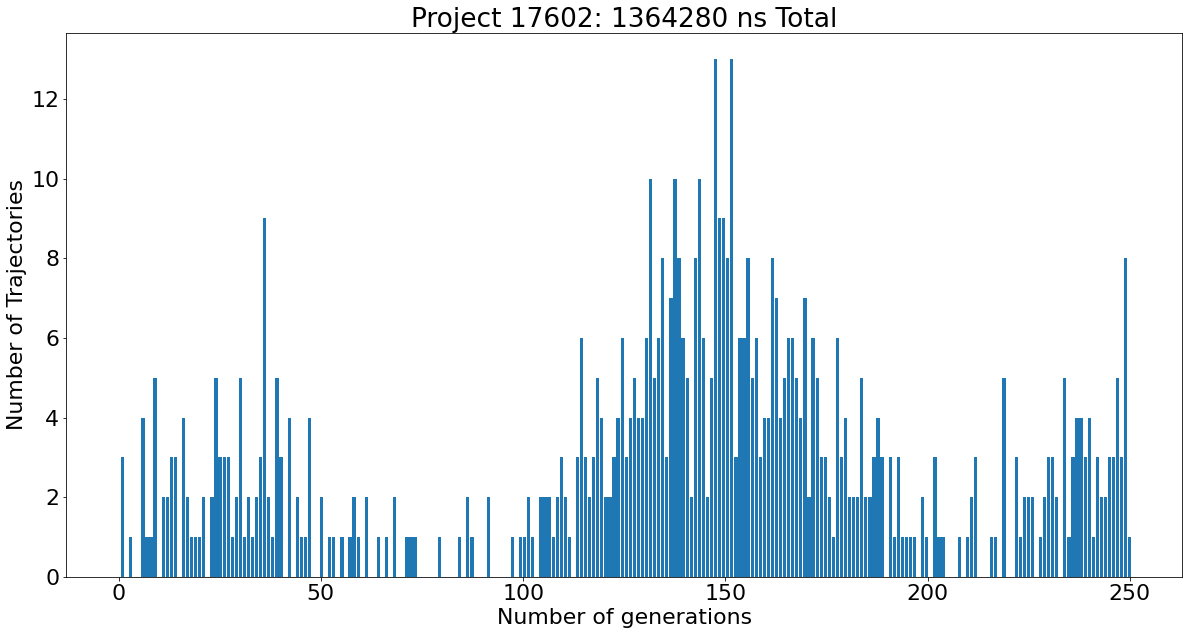

In [57]:
# Plot the histogram
ax = plt.figure(figsize=(20,10))
plt.bar(gen_vals, wu_hist_trunc)    
plt.xlabel("Number of generations")
plt.ylabel("Number of Trajectories")
plt.title("Project %s: %s ns Total" % (project_number, wu_total*num_ns_per_wu))
plt.show()


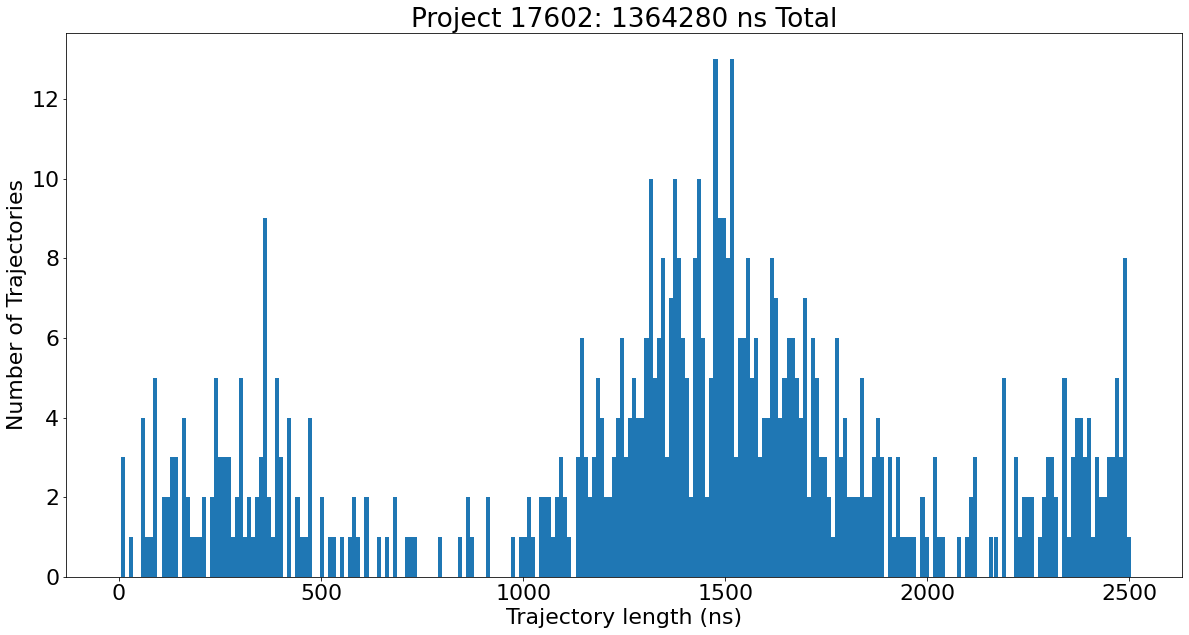

In [58]:
# Plot the histogram but for trajectory length
plt.figure(figsize=(20,10))
plt.bar(gen_vals*num_ns_per_wu,wu_hist_trunc, width=num_ns_per_wu)
plt.xlabel("Trajectory length (ns)")
plt.ylabel("Number of Trajectories")
plt.title("Project %s: %s ns Total" % (project_number, wu_total*num_ns_per_wu))
# plt.savefig("/home/sukrit/downloads/progress-%s.png" % str(project_number), dpi=300)
plt.show()

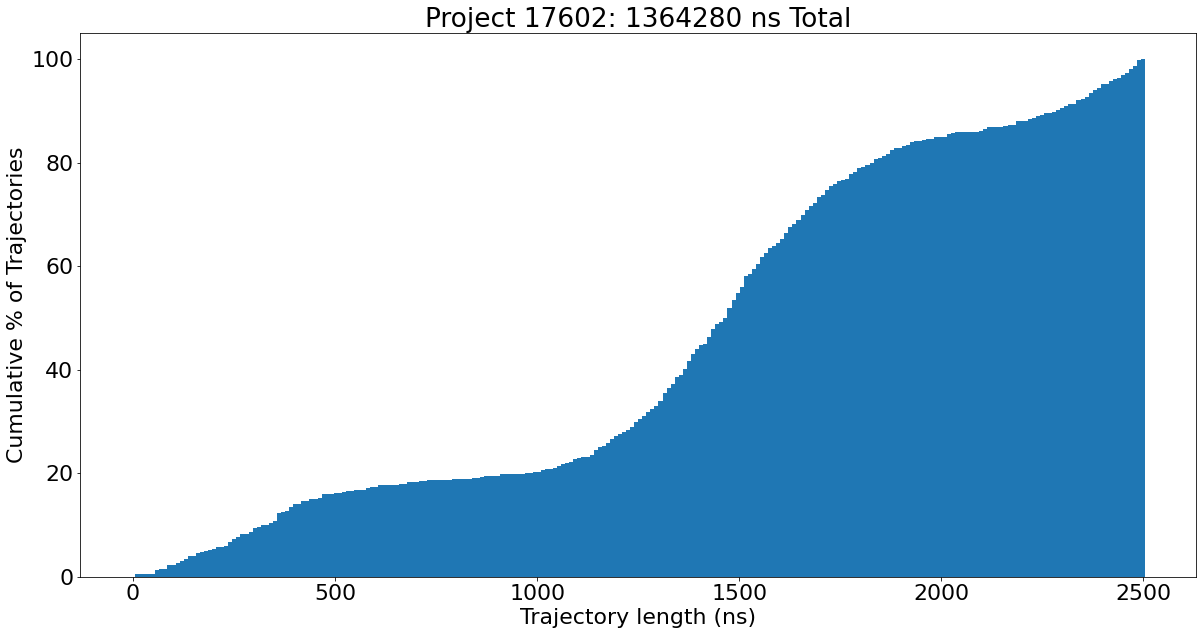

In [59]:
# Plot the cumulative histogram along trajectory length
plt.figure(figsize=(20,10))

# Get the cumulative histogram
cum_hist = np.cumsum(wu_hist_trunc)/np.sum(wu_hist_trunc)
plt.bar(gen_vals*num_ns_per_wu,cum_hist*100, width=num_ns_per_wu)
plt.xlabel("Trajectory length (ns)")
plt.ylabel("Cumulative % of Trajectories")
plt.title("Project %s: %s ns Total" % (project_number, wu_total*num_ns_per_wu))
plt.show()

# Requesting job-level information for detailed parsing

In [60]:
# use requests to get the project data
r = requests.get("%s/api/projects/%s/jobs" % (work_server_url, project_number), 
                 cert=(license_path, key_path))
job_data = r.json()

In [61]:
# confirm everything returned okay
if 'error' in job_data.keys(): 
    print('Issue')
else:
    print("Job data received successfully")

Job data received successfully


In [62]:
wu_data = job_data['jobs']
num_runs = project_data['runs']
print("Number of runs: %s" % num_runs)

Number of runs: 83


In [63]:
# Create a list of lists whose length is defined by num_runs
wu_data_runs = [[] for i in range(num_runs)]

# Iterate through each element of wu_data, and add wu_data['gen'] to the appropriate index
# The appropriate index is defined by wu_data['run']
for wu in wu_data:
    wu_data_runs[wu['run']].append(wu['gen'])


/tmp/ipykernel_252513/2403908360.py:9: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig("/home/sukrit/downloads/progress-%s.png" % str(project_number), dpi=300)
/home/sukrit/anaconda3/envs/fah-leveldb/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


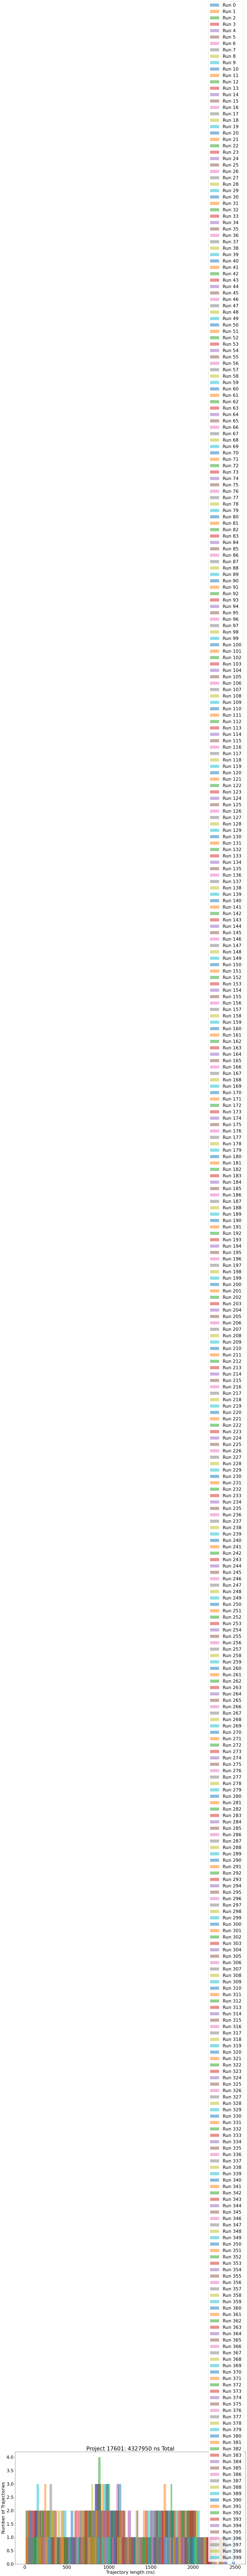

In [18]:
# Plot the histogram but for trajectory length for each run
plt.figure(figsize=(20,10))
for i in range(num_runs):
    plt.hist(np.array(wu_data_runs[i])*num_ns_per_wu, bins=50, histtype='bar', label="Run %s" % i, alpha=0.5)
plt.xlabel("Trajectory length (ns)")
plt.ylabel("Number of Trajectories")
plt.title("Project %s: %s ns Total" % (project_number, wu_total*num_ns_per_wu))
plt.legend()
plt.savefig("/home/sukrit/downloads/progress-%s.png" % str(project_number), dpi=300)
plt.show()


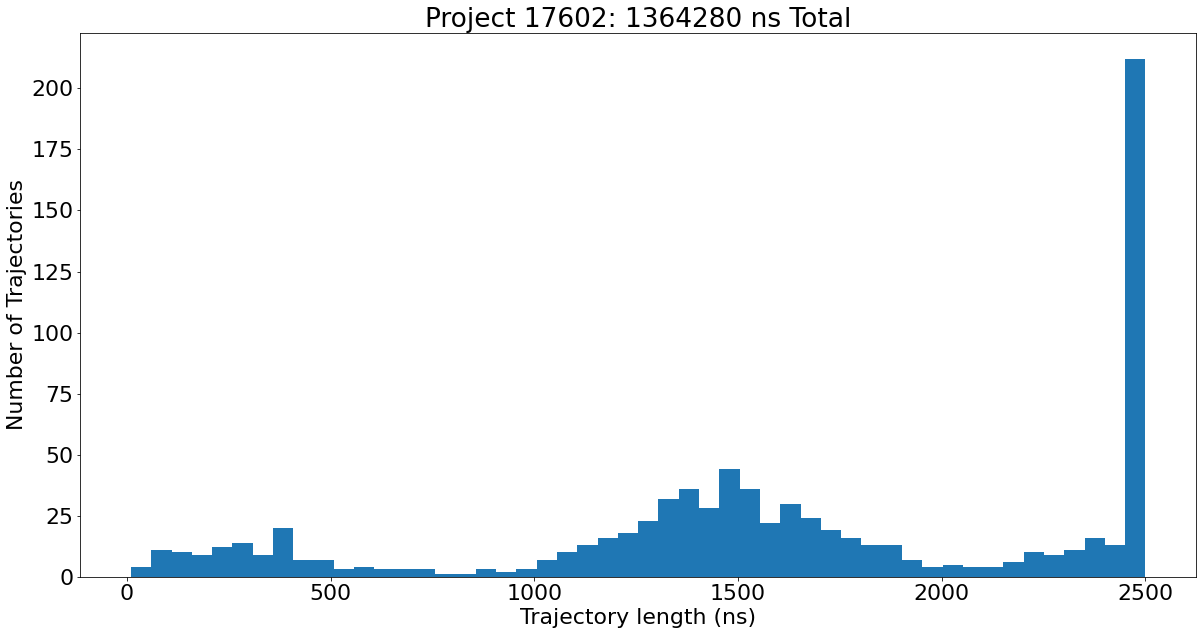

In [64]:
# Plot the histogram but for trajectory length for each run
plt.figure(figsize=(20,10))
hist_vals = np.concatenate(wu_data_runs)*num_ns_per_wu
# for i in range(num_runs):
plt.hist(hist_vals, bins=50, histtype='bar')
plt.xlabel("Trajectory length (ns)")
plt.ylabel("Number of Trajectories")
plt.title("Project %s: %s ns Total" % (project_number, wu_total*num_ns_per_wu))
# plt.legend()
plt.savefig("/home/sukrit/downloads/progress-%s.png" % str(project_number), dpi=300)
plt.show()